# TUTORIAL: ALTERNATIVE IMAGE PRE-PROCESSING TECHNIQUES
Author: Jaime Pastor

The goal of this notebook is to expose alternative techniques (other than those used by the winner of the Kaggle competition) to pre-process the images (spectrograms) 

For brevity purposes, we'll only expose those that we found succesful/appropriate for this dataset.

In [3]:
# Set path to directory with folders train and test
path_data = '/Users/jaime/Documents/datasets/mlprojectdata/data/'

In [9]:
import aifc
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import mlab, cm
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.signal import wiener, detrend
from skimage import exposure
# import scipy.signal as ss

In [22]:
# Let's first define some helper functions

# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()

# Function to allow code reusability
def plot_spectrogram(ax, P):
    plt.imshow(P, origin='lower', extent=[-6,6,-1,1], aspect=4, cmap = cm.get_cmap('bwr'))
    loc = plticker.MultipleLocator(base=3.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_xticklabels(np.arange(-0.5,2.5,0.5))
    ax.set_yticklabels(range(0,1001,250))
    ax.set_xlabel('Time (seconds)', fontsize = 12)
    ax.set_ylabel('Frequency (Hz)', fontsize = 12)
    cbar = plt.colorbar()
    cbar.set_label('Amplitude', fontsize = 12)

def plot_side_by_side(P,Q,title1):
    fig = plt.figure(figsize = (14,4))
    ax1 = plt.subplot(121)
    plot_spectrogram(ax1, P)
    ax2 = plt.subplot(122)
    plot_spectrogram(ax2, Q)
    plt.suptitle(title1, fontsize = 16)
    plt.show()

The difference with the winner submission is: <br>
**- To increase the contrast: **Use **histogram equalization** instead of capping values outside mean ± 1.5 standard devation <br>
**- To filter the noise: **Use a combination of **detrending** (vertical and horizontal) and **Wiener filter** instead of removing local mean <br>

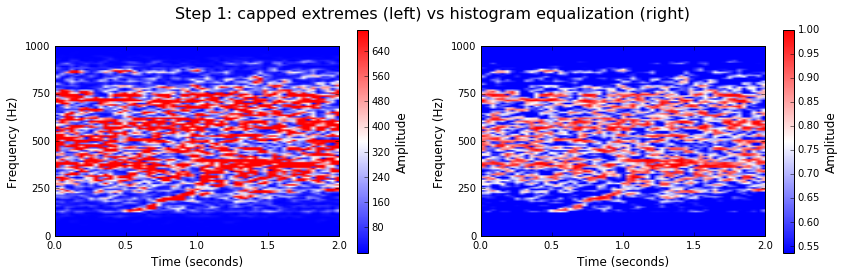

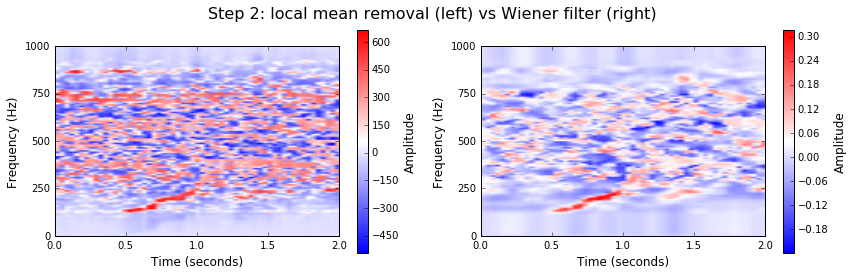

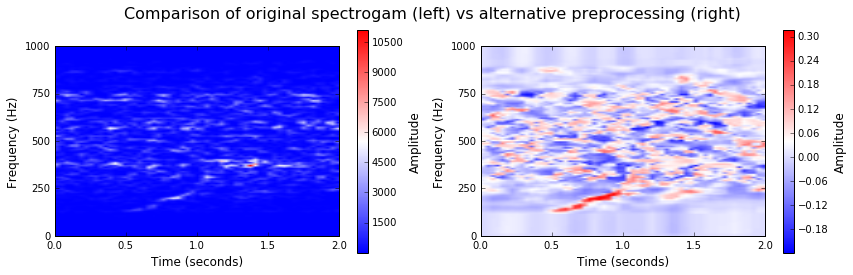

In [23]:
# Read one (whale) file as an example
params = {'NFFT':256, 'Fs':2000, 'noverlap':192} 
s = ReadAIFF(path_data + 'train/train7.aiff')
P, freqs, bins = mlab.specgram(s, **params)

m, n = P.shape
maxM=40
inner=3
outer=32

# Original capping of extreme values (Kaggle winner)
Q = P.copy()
mval, sval = np.mean(Q[:maxM,:]), np.std(Q[:maxM,:])
fact_ = 1.5
Q[Q > mval + fact_*sval] = mval + fact_*sval
Q[Q < mval - fact_*sval] = mval - fact_*sval
    
# Original local mean removal (Kaggle winner)
Q2 = Q.copy()
wInner = np.ones(inner)
wOuter = np.ones(outer)
for i in range(n):
    Q2[:,i] = Q2[:,i] - (np.convolve(Q2[:,i],wOuter,'same') - np.convolve(Q2[:,i],wInner,'same'))/(outer - inner)

# Histogram equalization (alternative)
T4 = exposure.equalize_hist(P, nbins = 65)

T5 = T4.copy()
# Detrend both vertically and horizontally  (alternative)
T5 = detrend(T5, axis = 1)
T5 = detrend(T5, axis = 0)
# Apply a Wiener filter (alternative)
T5 = wiener(T5, 4)

title = 'Step 1: capped extremes (left) vs histogram equalization (right)'
plot_side_by_side(Q, T4, title)
title = 'Step 2: local mean removal (left) vs Wiener filter (right)'
plot_side_by_side(Q2, T5, title)
title = 'Comparison of original spectrogam (left) vs alternative preprocessing (right)'
plot_side_by_side(P, T5, title)

As we can see in the plots in the middle, the alternative preprocessing manages to highlight the whale call while reducing the noise. 

## References:
- Scikit - Image <br>
http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.rescale_intensity <br>
http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html
- Docs Scikit <br>
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.wiener.html